In [1]:
import pandas as pd
import numpy as np
from os import system

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from IPython.display import Image

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import Perceptron
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

### Loading dataset

In [2]:
colnames=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country', 'income', 'capital']
df = pd.read_csv('adult.data', names=colnames, header=None)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,capital
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,NaN
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,NaN
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,NaN
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,NaN
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,NaN


#### Pre-Proccessing

In [3]:
# Load dataset 
print('We have in total ',len(df),' samples.')

We have in total  32561  samples.


**Columns containing \"?\" values**: 
There is no null value in the data but columns containing "?". There are different ways we could deal with this missing values. For example we could take the mean for conitinuous variables or the mode for categorical. But to keep our models decisicions more interpetable we decided to drop rows containing "?" for any column.

In [4]:
rows_to_remove = len(df) - len(df[(df.astype(str) != ' ?').all(axis=1)])
print('Removing ',rows_to_remove,'rows, containing \"?\" in one of the columns.') 
df = df[(df.astype(str) != ' ?').all(axis=1)]
print(len(df), 'rows remaining')

Removing  2399 rows, containing "?" in one of the columns.
30162 rows remaining


It is notable that the propotion of labels for inctances who are Maried ("Maried-civ-spouse" or "Maried-AF-spouse") is siginificantly different from the other marital status. Instances with marital status married have siginificantly more records with label 1.
**Note: We assumed that we could summarize this column to married or unmaried. But testing the classifiers showed a little better performance when keeping the values for this variables as it is.**

![Marital status image](marital_status.png "Marital status distribution")


**We also asumed that we could summarize the values for the column workclass to gov, self-employed and private as a big majoirty of the instances are belonging to the private workclass. Testing our classifiers showed that also for this variable we have a bit better performance when keeping the values for this column as it is**

In [5]:
# Create a new income_bi column
df['income_bi'] = df.apply(lambda row: 1 if '>50K'in row['income'] else 0, axis=1)

#Merge the columns capital gain and capital loss to one column 
df['capital'] = df['capital-gain'] - df['capital-loss']

#reduce the domain of workclass and marital-status fields
#df.loc[(df['workclass'].str.contains('gov')), 'workclass'] = 'gov'
#df.loc[(df['workclass'].str.contains('Self-emp')), 'workclass'] = 'self-emp'
#df.loc[(df['workclass'].str.contains('Private')), 'workclass'] = 'self-emp'

#df.loc[(df['marital-status'].str.contains('spouse')), 'marital-status'] = 'married-spouse'
#df.loc[(df['marital-status'].str.contains('spouse')), 'marital-status'] = 'married-spouse'
#df.loc[(~df['marital-status'].str.contains('spouse')), 'marital-status'] = 'other'


In [6]:
#Remove unnecesary columns
df = df.drop(['occupation','income', 'fnlwgt','capital-gain','capital-loss','native-country', 'relationship', 'education'], axis=1)

df.head()

,age,workclass,education-num,marital-status,race,sex,hours-per-week,capital,income_bi
0,39,State-gov,13,Never-married,White,Male,40,2174,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,White,Male,13,0,0
2,38,Private,9,Divorced,White,Male,40,0,0
3,53,Private,7,Married-civ-spouse,Black,Male,40,0,0
4,28,Private,13,Married-civ-spouse,Black,Female,40,0,0


In [7]:
# Use one-hot encoding on categorial columns
df = pd.get_dummies(df, columns=['workclass', 'marital-status', 'race', 'sex'])

df = df.rename(columns={"sex_ Female": "Gender"})
df = df.drop(['sex_ Male'], axis=1)
df.head()

,age,education-num,hours-per-week,capital,income_bi,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,Gender
0,39,13,40,2174,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,50,13,13,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,38,9,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,53,7,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,13,40,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## Split trains & test data

In [8]:
# split training and testing data (20/80)
df_train = df[:25000]
df_test = df[25000:]

X_train = df_train.drop(['income_bi'], axis=1)
y_train = df_train['income_bi']
X_test = df_test.drop(['income_bi'], axis=1)
y_test = df_test['income_bi']

print('Total data:',len(df),' Train+validation data:',len(df_train),' Test data: ',len(df_test))

Total data: 30162  Train+validation data: 25000  Test data:  5162


#### For training the SVM we use because of performance reasons a much smaller train and test set. Only 1000 datapoints. 

In [9]:
print('Propotion of positive class in train+validation data:', np.sum(y_train == 1) / np.sum(y_train == 0))
print('Propotion of positive class in test data:            ', np.sum(y_test == 1) / np.sum(y_test == 0))

Propotion of positive class in train+validation data: 0.3294336612603031
Propotion of positive class in test data:             0.3411275656014549


In [10]:
#Shuffle df
df = df.sample(frac = 1)

svm_df = df[29162:]

df_train_svm = svm_df[:800]
df_test_svm = svm_df[800:]

X_train_svm = df_train_svm.drop(['income_bi'], axis=1)
y_train_svm = df_train_svm['income_bi']
X_test_svm = df_test_svm.drop(['income_bi'], axis=1)
y_test_svm = df_test_svm['income_bi']

print('Total data for SVM:',len(svm_df),' Train+validation data for SVM:',len(df_train_svm),' Test data for SVM: ',len(df_test_svm))

Total data for SVM: 1000  Train+validation data for SVM: 800  Test data for SVM:  200


In [11]:
print('Propotion of positive class in train+validation data for SVM:', np.sum(y_train_svm == 1) / np.sum(y_train_svm == 0))
print('Propotion of positive class in test data for SVM:            ', np.sum(y_test_svm == 1) / np.sum(y_test_svm == 0))

Propotion of positive class in train+validation data for SVM: 0.3468013468013468
Propotion of positive class in test data for SVM:             0.28205128205128205


## Train the classifiers

In [12]:
dt = tree.DecisionTreeClassifier(criterion='gini', max_depth=10)
dt = dt.fit(X_train, y_train)

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(X_train, y_train)

nb = GaussianNB()
nb.fit(X_train, y_train)

perc = Perceptron(tol=1e-3, random_state=0)
perc.fit(X_train, y_train)

Perceptron()

## Evaluation of the classifiers

In [14]:
svm_cls = svm.SVC(kernel='linear')
svm_cls.fit(X_train_svm, y_train_svm)

SVC(kernel='linear')

#### 10 fold cross validation mean scores of the classifiers

In [13]:
for clf, clf_name in zip([dt, knn, nb, svm_cls, perc ], ['DT', 'KNN', 'NB', 'SVM', 'Perceptron:']):
    
    skf = StratifiedKFold(n_splits=10)
    print('Report for classifier ',clf_name,':')
    if(clf_name=='SVM'):
        y_pred_svm = cross_val_predict(clf, X_test_svm, y_test_svm, cv = skf)
        cv_report  = classification_report(y_test_svm, y_pred_svm, output_dict=True)
    else:
        y_pred    = cross_val_predict(clf, X_test, y_test, cv = skf )
        cv_report = classification_report(y_test, y_pred, output_dict=True)
    
    print('Accuracy:      '  ,cv_report['accuracy'])
    print('f1 class 0:    ',cv_report['0']['f1-score'])
    print('f1 class 1:    ',cv_report['1']['f1-score'])
    print('Precision class 0: ',cv_report['0']['precision'])
    print('Precision class 1: ',cv_report['1']['precision'])
    print('Recall class(Sensitivity) 0: ',cv_report['0']['recall'])
    print('Recall class 1: ',cv_report['1']['recall'])

NameError: name 'svm_cls' is not defined

#### Confusion matrices of the classifiers

DT
KNN
NB
SVM
Perceptron


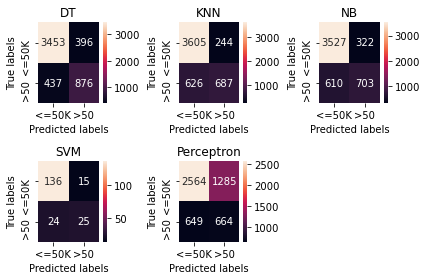

In [31]:
for i, (clf, clf_name) in enumerate(zip([dt, knn, nb, svm_cls, perc], ['DT', 'KNN', 'NB', 'SVM', 'Perceptron'])):
    
    if(clf_name=='SVM'):
        print(clf_name)
        y_pred_svm = cross_val_predict(clf, X_test_svm, y_test_svm, cv = skf )
        cm_dt = confusion_matrix(y_test_svm, y_pred_svm)
    else:
        print(clf_name)
        y_pred = cross_val_predict(clf, X_test, y_test, cv = skf )
        cm_dt = confusion_matrix(y_test, y_pred)

    ax= plt.subplot(2, 3, i+1)
    sns.heatmap(cm_dt, annot=True, fmt='g', ax=ax); 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(clf_name) 
    ax.xaxis.set_ticklabels(['<=50K', '>50']) 
    ax.yaxis.set_ticklabels(['<=50K', '>50'])
    
plt.tight_layout()
plt.savefig('cm_before_tuning.png')

#### Preformance summary of the classifiers

In [32]:
skf = StratifiedKFold(n_splits=10)
for clf, clf_name in zip([dt, knn, nb, perc], ['DT:', 'KNN:', 'NB:', 'Perceptron']):
    if(clf_name=='SVM'):
        print('skip svm')
        #y_pred_svm = cross_val_predict(clf, X_test_svm, y_test_svm, cv = 10 )
        #print(clf_name,'\n\n',classification_report(y_test_svm, y_pred_svm))
    else:
        y_pred = cross_val_predict(clf, X_test, y_test, cv = skf )
        print(clf_name,'\n\n',classification_report(y_test, y_pred))

DT: 

               precision    recall  f1-score   support

           0       0.89      0.90      0.89      3849
           1       0.69      0.67      0.68      1313

    accuracy                           0.84      5162
   macro avg       0.79      0.78      0.79      5162
weighted avg       0.84      0.84      0.84      5162

KNN: 

               precision    recall  f1-score   support

           0       0.85      0.94      0.89      3849
           1       0.74      0.52      0.61      1313

    accuracy                           0.83      5162
   macro avg       0.79      0.73      0.75      5162
weighted avg       0.82      0.83      0.82      5162

NB: 

               precision    recall  f1-score   support

           0       0.85      0.92      0.88      3849
           1       0.69      0.54      0.60      1313

    accuracy                           0.82      5162
   macro avg       0.77      0.73      0.74      5162
weighted avg       0.81      0.82      0.81      516

## Model parameter tuning

#### Note: As we have the class label imbalance we decided to tune the parameters for the best f1 score for the minorty class label.

### Decision tree

#### Testing different values for the hyperparameters max_depth, min sample size, criterien{gini,entropy}

In [33]:
skf = StratifiedKFold(n_splits=10)

In [34]:
params = {
    'max_depth': [1, 3, 5, 7, 9, 11, 15, 20],
    'min_samples_split': [0.01, 0.02, 0.03, 0.04, 0.05],
    'criterion': ["gini", "entropy"],
    }
grid_search = GridSearchCV(estimator=dt, param_grid=params, cv = skf, n_jobs=-1, verbose=1, scoring = 'f1')
grid_search.fit(X_train, y_train)
score_df = pd.DataFrame(grid_search.cv_results_)
dt_best = grid_search.best_estimator_
best_criterion = dt_best.get_params()['criterion']
best_maxdepth = dt_best.get_params()['max_depth']
best_min_sample_leaf = dt_best.get_params()['min_samples_split']
print("\n" , score_df.nlargest(5,"mean_test_score"))
print("\nChosen parameters: ", dt_best)
print("\nBest criterion: ", best_criterion)
print("\nBest max depth: ", best_maxdepth)
print("\nBest min samples leaf: ", best_min_sample_leaf) 
print("\n", classification_report(y_test, dt_best.predict(X_test))) 

Fitting 10 folds for each of 80 candidates, totalling 800 fits

     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
70       0.222505      0.016975         0.008179        0.001394   
30       0.224300      0.012452         0.009175        0.003332   
75       0.226794      0.009672         0.008678        0.001895   
71       0.211435      0.007853         0.009674        0.003368   
35       0.227293      0.010531         0.008477        0.001683   

   param_criterion param_max_depth param_min_samples_split  \
70         entropy              15                    0.01   
30            gini              15                    0.01   
75         entropy              20                    0.01   
71         entropy              15                    0.02   
35            gini              20                    0.01   

                                               params  split0_test_score  \
70  {'criterion': 'entropy', 'max_depth': 15, 'min...           0.667780   
3

### Effect of model parameters for Decision Tree

#### Effect of max_depth parameter

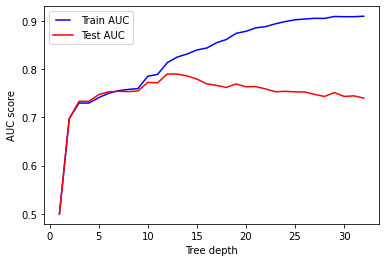

In [35]:
max_depths = np.array([1, 3, 5, 7, 9, 11, 15, 20])
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_prediction_dt = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_prediction_dt)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_prediction_dt = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_prediction_dt)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

#### Effect of min_sample_leaf parameter

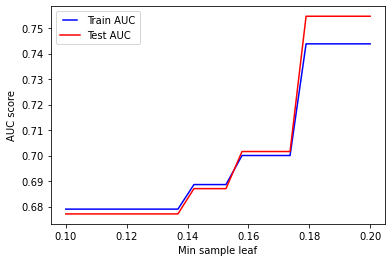

In [36]:
min_samples_leafs  = np.array([0.01, 0.02, 0.03, 0.04, 0.05])
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    train_prediction_dt = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_prediction_dt)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_prediction_dt = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_prediction_dt)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Min sample leaf')
plt.show()

### KNN

#### Trying our different values for the hyperparameter k of the KNN classifier 

In [37]:
params = {
    'n_neighbors': [3, 5, 8, 10, 15, 20],
    'p': [1,2]
    }

grid_search = GridSearchCV(estimator=knn, param_grid=params, cv=skf, n_jobs=-1, scoring = 'f1')
grid_search.fit(X_train, y_train)
score_knn = pd.DataFrame(grid_search.cv_results_)
knn_best = grid_search.best_estimator_
best_n = knn_best.get_params()['n_neighbors']
best_leaf_size = knn_best.get_params()['leaf_size']
best_p = knn_best.get_params()['p']
print("\n" , score_knn.nlargest(5,"mean_test_score"))
print("\nChosen parameters: ", knn_best)
print("\nBest neighbor size: ", best_n)
print("\nBest leaf size: ", best_leaf_size)
print("\nBest p: ", best_p)
print("\n", classification_report(y_test, knn_best.predict(X_test)))


     mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
8        0.062733      0.014990        35.374047       25.674425   
3        0.116688      0.136481        14.910853        8.597776   
2        0.040193      0.007517        80.585338        0.702684   
9        0.057247      0.027636        32.131617       22.627884   
10       0.056948      0.038232        57.599148       19.997196   

   param_n_neighbors param_p                       params  split0_test_score  \
8                 15       1  {'n_neighbors': 15, 'p': 1}           0.679862   
3                  5       2   {'n_neighbors': 5, 'p': 2}           0.655490   
2                  5       1   {'n_neighbors': 5, 'p': 1}           0.664457   
9                 15       2  {'n_neighbors': 15, 'p': 2}           0.643042   
10                20       1  {'n_neighbors': 20, 'p': 1}           0.659459   

    split1_test_score  split2_test_score  split3_test_score  \
8            0.655507           0.660107     

### Effect of model parameters for k-Nearest Neighbors

#### Effect of n_neighbors parameter

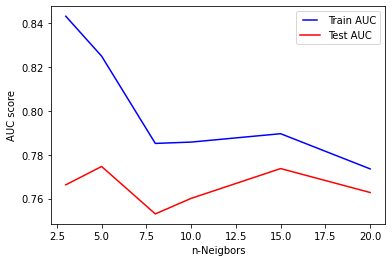

In [51]:
n_neighborss = np.array([3, 5, 8, 10, 15, 20])
train_results = []
test_results = []
for n_neighbors in n_neighborss:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    train_prediction_knn = knn.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_prediction_knn)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_prediction_knn = knn.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_prediction_knn)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(n_neighborss, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_neighborss, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n-Neigbors')
plt.show()

### Naive Bayes

**Trying to assign weights to samples to cope with label imbalance**

Without assigning weights to samples:

In [40]:
nb = GaussianNB()
nb.fit(X_train, y_train)

pred = nb.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      3849
           1       0.71      0.54      0.61      1313

    accuracy                           0.83      5162
   macro avg       0.78      0.73      0.75      5162
weighted avg       0.82      0.83      0.82      5162



With assigning weights to samples:

In [41]:
from sklearn.utils import class_weight

sample = class_weight.compute_sample_weight('balanced', y_train)

#Classifier Naive Bayes
nb = GaussianNB()
nb.fit(X_train,y_train, sample_weight=sample)
w_pred = nb.predict(X_test)
print(classification_report(y_test, w_pred))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      3849
           1       0.62      0.72      0.67      1313

    accuracy                           0.82      5162
   macro avg       0.76      0.79      0.77      5162
weighted avg       0.83      0.82      0.82      5162



**Trying with bernoulli naive bayes as we have many binarized variables**

In [42]:
bern_nb = BernoulliNB()
bern_nb.fit(X_train, y_train)

bern_pred = bern_nb.predict(X_test)
print(classification_report(y_test, bern_pred))

              precision    recall  f1-score   support

           0       0.89      0.71      0.79      3849
           1       0.47      0.75      0.58      1313

    accuracy                           0.72      5162
   macro avg       0.68      0.73      0.69      5162
weighted avg       0.79      0.72      0.74      5162



In [43]:
sample = class_weight.compute_sample_weight('balanced', y_train)

#Classifier Naive Bayes
bern_nb = BernoulliNB()
bern_nb.fit(X_train, y_train, sample_weight=sample)

bern_pred = bern_nb.predict(X_test)
print(classification_report(y_test, bern_pred))

              precision    recall  f1-score   support

           0       0.93      0.66      0.77      3849
           1       0.46      0.85      0.60      1313

    accuracy                           0.71      5162
   macro avg       0.70      0.76      0.69      5162
weighted avg       0.81      0.71      0.73      5162



**Conlusion Naive Bayes:** We see a small improvemen on the f1-score for the positive class from 61 to 67 when using weighted Gausian Navie Bayes. But to the cost of the accuracy dropping from 83 to 82.

### Effect of model parameters for naive bayes

#### Bernoulli vs Gausian

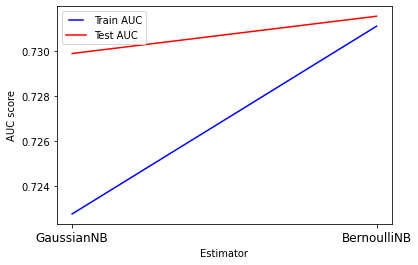

In [44]:
estimator = [GaussianNB(), BernoulliNB()]
train_results = []
test_results = []
for i in range(len(estimator)):
    nb = estimator[i]
    nb.fit(X_train, y_train)
    train_prediction_nb = nb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_prediction_nb)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_prediction_nb = nb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_prediction_nb)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

estStr = ['GaussianNB', 'BernoulliNB']
index = np.arange(len(estimator))
line1, = plt.plot([0,1], train_results, 'b', label='Train AUC')
line2, = plt.plot([0,1], test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Estimator')
plt.xticks(index, estStr, fontsize = 12)
plt.show()

#### Effect of var_smoothing parameter

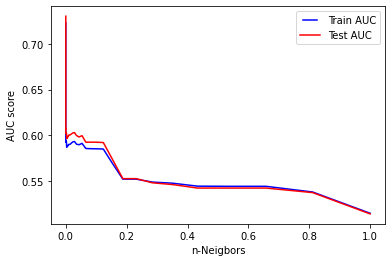

In [45]:
var_smoothings = np.logspace(0,-9, num=100, endpoint = True)
train_results = []
test_results = []
for var_smoothing in var_smoothings:
    nb = GaussianNB(var_smoothing = var_smoothing)
    nb.fit(X_train, y_train)
    train_prediction_nb = nb.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_prediction_nb)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_prediction_nb = nb.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_prediction_nb)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(var_smoothings, train_results, 'b', label='Train AUC')
line2, = plt.plot(var_smoothings, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n-Neigbors')
plt.show()

### Support Vector Machine

#### Trying our different values for the hyperparameter k of the KNN classifier

In [46]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
regularization = [0.4, 0.6, 0.8, 1]

params = np.array(np.meshgrid( kernel, regularization)).T.reshape(-1, 2)
scores = []

scores = {'kernel':[],
          'C':[],
          'accuracy':[], 
          'precisionc0':[], 
          'recall0':[], 
          'precisionc1':[], 
          'recall1':[], 
          'f1c0':[], 
          'f1c1':[]}
 
# Create DataFrame
scores_df = pd.DataFrame(scores)

for param in params:
    skf = StratifiedKFold(n_splits=10)
    svm_cls = svm.SVC(kernel=param[0], C=float(param[1]))
    svm_cls.fit(X_train_svm, y_train_svm)
    
    y_pred = cross_val_predict(svm_cls, X_test_svm, y_test_svm, cv = skf )
    cv_report = classification_report(y_test_svm, y_pred, output_dict=True)
    
    scores_df.loc[len(scores_df.index)] = [param[0], 
                                           float(param[1]),
                                           cv_report['accuracy'],
                                           cv_report['0']['precision'],
                                           cv_report['1']['precision'],
                                           cv_report['0']['recall'],
                                           cv_report['1']['recall'],
                                           cv_report['0']['f1-score'],
                                           cv_report['1']['f1-score']]

In [47]:
scores_df.sort_values(['f1c1'], ascending = [False])

,kernel,C,accuracy,precisionc0,recall0,precisionc1,recall1,f1c0,f1c1
2,linear,0.8,0.815,0.851852,0.657895,0.913907,0.510204,0.881789,0.574713
3,linear,1.0,0.805,0.850000,0.625000,0.900662,0.510204,0.874598,0.561798
1,linear,0.6,0.800,0.840491,0.621622,0.907285,0.469388,0.872611,0.534884
0,linear,0.4,0.800,0.828402,0.645161,0.927152,0.408163,0.875000,0.500000
11,rbf,1.0,0.815,0.803191,1.000000,1.000000,0.244898,0.890855,0.393443
9,rbf,0.6,0.805,0.794737,1.000000,1.000000,0.204082,0.885630,0.338983
10,rbf,0.8,0.805,0.794737,1.000000,1.000000,0.204082,0.885630,0.338983
12,sigmoid,0.4,0.800,0.793651,0.909091,0.993377,0.204082,0.882353,0.333333
13,sigmoid,0.6,0.795,0.792553,0.833333,0.986755,0.204082,0.879056,0.327869
14,sigmoid,0.8,0.795,0.792553,0.833333,0.986755,0.204082,0.879056,0.327869


In [48]:
best_kernel = scores_df.iloc[scores_df['f1c1'].argmax()]['kernel']
best_C = scores_df.iloc[scores_df['f1c1'].argmax()]['C']
svm_cls = svm.SVC(kernel=best_kernel, C=float(best_C))
svm_cls.fit(X_train_svm, y_train_svm)
y_pred = svm_cls.predict(X_test_svm)
print(classification_report(y_test_svm, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       151
           1       0.64      0.51      0.57        49

    accuracy                           0.81       200
   macro avg       0.75      0.71      0.72       200
weighted avg       0.80      0.81      0.80       200



### Effect of model parameters for Support Vector Machine

#### Effect of kernel

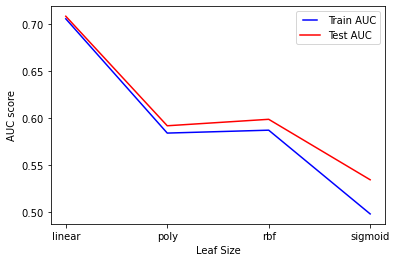

In [82]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
train_results = []
test_results = []
for kernel in kernels:
    svm_cls = svm.SVC(kernel=kernel)
    svm_cls.fit(X_train_svm, y_train_svm)
    train_prediction_svm_cls = svm_cls.predict(X_train_svm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_svm, train_prediction_svm_cls)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_prediction_svm_cls = svm_cls.predict(X_test_svm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_svm, test_prediction_svm_cls)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(kernels, train_results, 'b', label='Train AUC')
line2, = plt.plot(kernels, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Kernels')
plt.show()

#### Effect of regularization

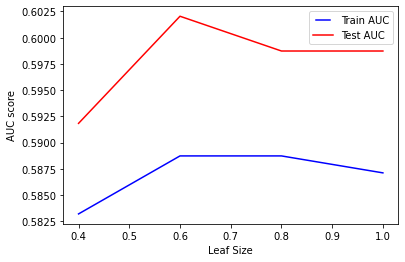

In [81]:
regulariations = [0.4, 0.6, 0.8, 1]
train_results = []
test_results = []
for regulariation in regulariations:
    svm_cls = svm.SVC(C=regulariation)
    svm_cls.fit(X_train_svm, y_train_svm)
    train_prediction_svm_cls = svm_cls.predict(X_train_svm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train_svm, train_prediction_svm_cls)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_prediction_svm_cls = svm_cls.predict(X_test_svm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_svm, test_prediction_svm_cls)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(regulariations, train_results, 'b', label='Train AUC')
line2, = plt.plot(regulariations, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Leaf Size')
plt.show()

### Perceptron

#### Trying our different values for the hyperparameter hidden_layer_sizes, activation, alpha and learning rate

In [64]:
params = {
    'alpha': [0.00001, 0.0001, 0.0002, 0.001, 0.002, 0.05]
    }

grid_search = GridSearchCV(estimator=perc, param_grid=params, cv = skf, n_jobs=-1, verbose=1, scoring = "accuracy")
grid_search.fit(X_train, y_train)
score_df = pd.DataFrame(grid_search.cv_results_)
perc_best = grid_search.best_estimator_
best_alpha = perc_best.get_params()['alpha']
print("\n" , score_df.nlargest(5,"mean_test_score"))
print("\nChosen parameters: ", perc_best)
print("\nBest alpha: ", best_alpha)                                           
print("\n", classification_report(y_test, dt_best.predict(X_test))) 

Fitting 10 folds for each of 6 candidates, totalling 60 fits

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.120175      0.038550         0.006880        0.000941     0.00001   
1       0.155884      0.038484         0.006882        0.000828      0.0001   
2       0.155983      0.035646         0.007780        0.001596      0.0002   
3       0.176726      0.026577         0.007980        0.003154       0.001   
4       0.160870      0.030155         0.007479        0.001428       0.002   

              params  split0_test_score  split1_test_score  split2_test_score  \
0   {'alpha': 1e-05}             0.7732             0.7744             0.7732   
1  {'alpha': 0.0001}             0.7732             0.7744             0.7732   
2  {'alpha': 0.0002}             0.7732             0.7744             0.7732   
3   {'alpha': 0.001}             0.7732             0.7744             0.7732   
4   {'alpha': 0.002}             0.7732             0.774

### Effect of model parameters forPerceptron

#### Effect of alpha parameter

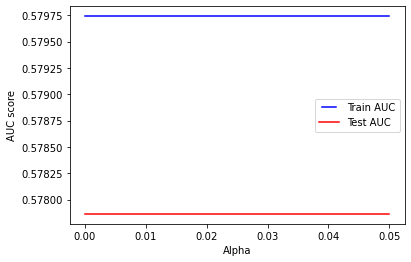

In [65]:
alphas = np.array([0.00001, 0.0001, 0.0002, 0.001, 0.002, 0.05])
train_results = []
test_results = []
for alpha in alphas:
    perc = Perceptron(alpha=alpha)
    perc.fit(X_train, y_train)
    train_prediction_perc = perc.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_prediction_perc)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    test_prediction_perc = perc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_prediction_perc)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

line1, = plt.plot(alphas, train_results, 'b', label='Train AUC')
line2, = plt.plot(alphas, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Alpha')
plt.show()

**Confusion matrices before hyperparameter tuning for comparison**
![Confusion matrices before hyperparameter tuning](cm_before_tuning.png "Confusion matrices before hyperparameter tuning")

In [74]:
# Fit a decision tree
dt = tree.DecisionTreeClassifier(criterion=best_criterion,max_depth=best_maxdepth, min_samples_split=0.02)
dt = dt.fit(X_train, y_train)

In [75]:
knn_clf = KNeighborsClassifier(n_neighbors=best_n, leaf_size=best_leaf_size, p=best_p)
knn.fit(X_train, y_train)

nb = GaussianNB()
nb.fit(X_train, y_train)

perc = Perceptron(tol=1e-3, random_state=0)
perc.fit(X_train, y_train)

Perceptron()

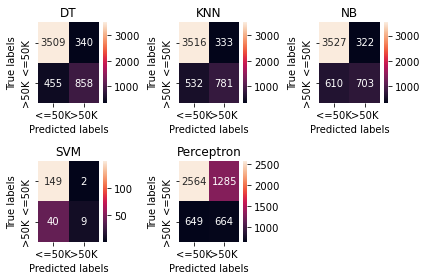

In [76]:
for i, (clf, clf_name) in enumerate(zip([dt, knn_clf, nb, svm_cls, perc], ['DT', 'KNN', 'NB', 'SVM', 'Perceptron'])):
    
    if(clf_name=='SVM'):
        y_pred_svm = cross_val_predict(clf, X_test_svm, y_test_svm, cv = 10 )
        cm_dt = confusion_matrix(y_test_svm, y_pred_svm)
    else:
        y_pred = cross_val_predict(clf, X_test, y_test, cv = 10 )
        cm_dt = confusion_matrix(y_test, y_pred)

    ax= plt.subplot(2, 3, i+1)
    sns.heatmap(cm_dt, annot=True, fmt='g', ax=ax); 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(clf_name) 
    ax.xaxis.set_ticklabels(['<=50K', '>50K']) 
    ax.yaxis.set_ticklabels(['<=50K', '>50K'])
    
plt.tight_layout()
plt.savefig('cm_after_tuning.png')

## Model interpretation/visualization

#### Decision Tree

The tree is broad and depth making it harder for intpretation and it also indicates some overfitting to the training data. 
Durring the parameter truning we also tested larger values for the parameters **min_sample_leaf** and **min_samples_split** to avoid nodes and leaves containing very less samples. But we faced drop in train and also **test performance**. 

'max_depth': 12.0<br />
'min_samples_leaf': 0.0009, around 24 samples 0.0009*(0.9*30162) <br />
'min_samples_split': 0.001, around 27 samples 0.001*(0.9*30162)<br />

We could had tested following parameter:<br />
'min_impurity_decrease': 0.0

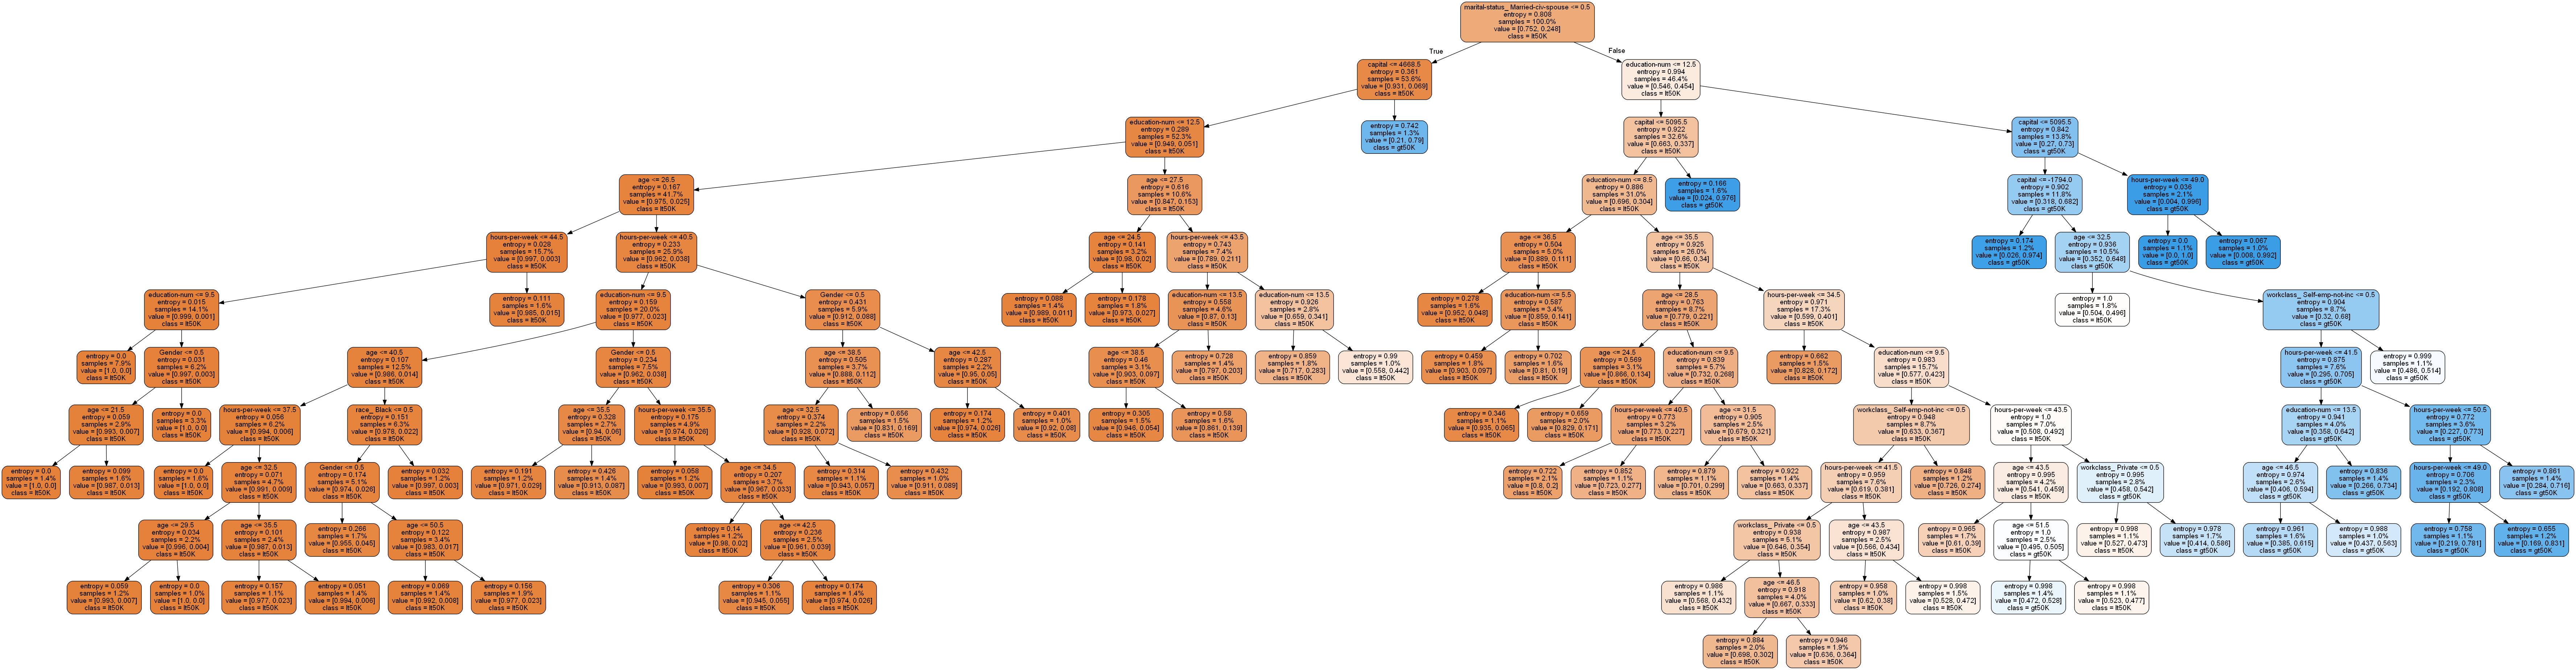

In [77]:
# Fit a decision tree
dt = tree.DecisionTreeClassifier(criterion=best_criterion,max_depth=best_maxdepth, min_samples_leaf=best_min_sample_leaf)
dt = dt.fit(X_train, y_train)

# Visualize tree
dot_data = tree.export_graphviz(dt, label='all', impurity=True, proportion=True, 
                               feature_names=list(X_train), class_names=['lt50K', 'gt50K'],
                               filled=True, rounded=True, out_file='tree.dot')

graph = graphviz.Source(dot_data)
graph
system("dot -Tpng tree.dot -o tree.png")
Image("tree.png")

#### The variables which has high feature importance (decrease in impurity) are the variables we saw a higher correlation durring our data analyis. 

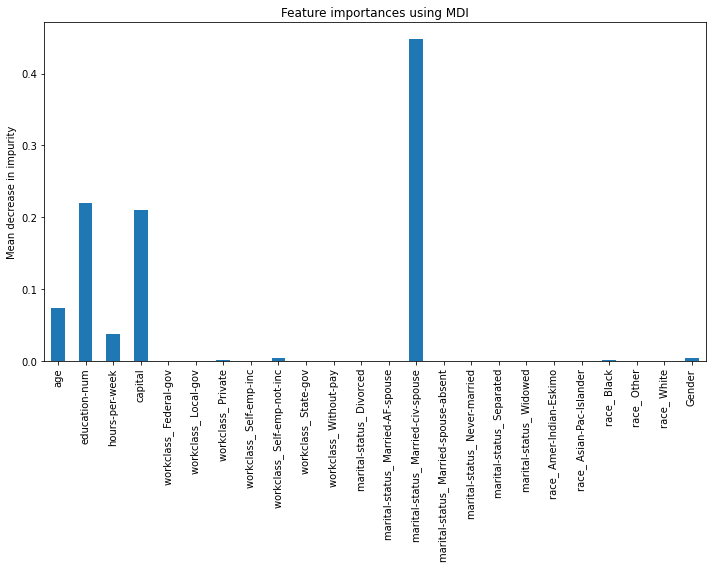

In [78]:
importances = dt.feature_importances_
forest_importances = pd.Series(importances, index=X_test.columns)
std = np.std([dt.tree_.compute_feature_importances(normalize=True) for tree in dt.tree_.compute_feature_importances(normalize=True)], axis=0)

fig, ax = plt.subplots(figsize=(10, 8))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### We tried some visualization with applying dimensionality reduction but wanst able to finish.

In [ ]:
predictions = dt.predict_proba(X_test)
print(roc_auc_score(y_test, predictions[:,1]))
fpr, tpr, _ = roc_curve(y_test, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
#mds = MDS(n_components=dim, dissimilarity='precomputed', random_state=0)

principalComponents = pca.fit_transform(X_test)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca1', 'pca2', 'pca3'])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pca1', fontsize = 15)
ax.set_ylabel('pca2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r', 'g', 'b']

ax.scatter(principalDf['pca1'], principalDf['pca2'], c = y_pred, s = 15)
ax.grid()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pca1', fontsize = 15)
ax.set_ylabel('pca3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r', 'g', 'b']

ax.scatter(principalDf['pca1'], principalDf['pca3'], c = y_pred, s = 15)
ax.grid()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('pca2', fontsize = 15)
ax.set_ylabel('pca3', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
colors = ['r', 'g', 'b']

ax.scatter(principalDf['pca2'], principalDf['pca3'], c = y_pred, s = 15)
ax.grid()

In [ ]:
plt.figure(figsize=(20,16),dpi= 100)
ax = plt.subplot(1,2,1, projection='3d')#,figsize=(24,20))

colors = [(0.1215, 0.4667, 0.7059, 0.2), 
          (1.0000, 0.4980, 0.0550, 1)]
cmap = ListedColormap(colors)

ax.scatter(
    xs=principalDf['pca1'], 
    ys=principalDf['pca2'], 
    zs=principalDf['pca3'], 
    c= bern_pred, 
    cmap=cmap
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-tree')

plt.tight_layout()

# plt.gcf().set_size_inches(36, 32)
plt.savefig('PCA_NB.jpg')
plt.show()

In [ ]:
from matplotlib.colors import ListedColormap
plt.figure(figsize=(20,16),dpi= 100)
ax = plt.subplot(1,2,1, projection='3d')#,figsize=(24,20))

colors = [(0.1215, 0.4667, 0.7059, 0.2), 
          (1.0000, 0.4980, 0.0550, 1)]
cmap = ListedColormap(colors)

ax.scatter(
    xs=principalDf['pca1'], 
    ys=principalDf['pca2'], 
    zs=principalDf['pca3'], 
    c= y_pred, 
    cmap=cmap
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-tree')

plt.tight_layout()

# plt.gcf().set_size_inches(36, 32)
plt.savefig('PCA_NB.jpg')
plt.show()